In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import scipy.stats as stats
truncnorm = stats.truncnorm
truncexp = stats.truncexpon
%matplotlib inline

In [2]:
# Oracle for a given weights matrix
def dijk(w):
    # Dijkstra
    # set initial conditions
    L = int(math.sqrt(len(w))) # number of vertices
    w = w.reshape(L,L)
    unvisited = list(range(L))
    distances = [np.inf]*L
    distances[0] = 0
    paths = [[0]]*L

    while len(unvisited) > 0:
        i = np.argmin([distances[i] for i in unvisited])
        v = unvisited[i]
        unvisited.pop(i)
        for u in range(L):
            if distances[u] > distances[v] + w[v, u]:
                distances[u] = distances[v] + w[v, u]
                paths[u] = paths[v][:]
                paths[u].append(u)
    
    short = paths[-1]
    # store observed paths
    A = np.arange(L**2).reshape(L,L)
    out = []
    for i in range(len(short)-1):
        out.append(A[short[i], short[i+1]])
        
    A = np.zeros(L**2)
    A[out] = 1
    return(out, A)

In [ ]:
V = 10
L = V*V
diag_zero = np.ones(L).reshape(V, V) - np.diag(np.ones(V))

path_means1 = np.zeros(L).reshape(V, V)
for i in range(V):
    for j in range(V):
        path_means1[i,j] = abs(i - j)/V - 1/(V*2)
path_means1 = abs(path_means1 * diag_zero)*10
plt.pcolormesh(np.repeat(dijk(path_means1.reshape(L,))[1],10).reshape(L,10))

In [6]:
upper = np.amax(path_means1)
lower = np.amin(path_means1)
path_means2 = np.random.uniform(0, 1, L).reshape(V, V) * diag_zero
path_means2[0,-1] = 1 # to try to make sure best path isn't to go straight to the end!

In [11]:
# Wan, Kveton and Ashkan 2015 CombLinTS algorithm
# Should work better than other algorithms when L is very large as doesn't depend on L
# Makes use of Lxd generalization matrix Φ of features for each element of E
# w̄ lies on or close to subspace span of Φ
# define θ∗ = argmin_θ ||w̄ − Φθ||_2
# could think of features as for example knowledge of other activities/events which affects outcome - 
# like characteristics of movies which could predict rating??


# Scenario: User knows Φ matrix of activities/events
# At each stage user samples coefficients θ used to estimate w̄
# and uses this estimate with oracle to determine which move to play
# observes weight for each play and updates parameters of θ sampling accordingly

### Set parameters
#L = 16 # 4x4 grid with 16 possible edges
lambda_true = 0.1 # (used to generate true coefficients of Φ which are then used to calculate w̄ )
sigma_true = 0.2 # (used when adding noise to true w at each iteration)
d = L
#phi = np.random.normal(0, 1, (L,d))
phi = np.eye(L)
#phi = np.random.uniform(0, 1, L*d).reshape(L,d)
#theta_opt = np.random.multivariate_normal([0]*d, np.diag([lambda_true**2]*d))
w_bar = path_means1.reshape(L,)
#w_bar = np.array([0,100,1,100,5,0,5,1,5,1,0,100,5,5,5,0])
#w_bar = np.array([0,10,1,100,5,0,5,1,5,1,0,100,5,5,5,0])
theta_opt = np.linalg.solve(phi,w_bar)

In [12]:
# Shortest path case for toy example
iters = 1000
w_est = np.zeros((L, iters))
w_actual = np.zeros((L, iters))
A = np.zeros((L, iters))
theta = np.zeros((d, iters+1))
### INIT
t=0
lamb = 10
sigma = 1
cov_mat = [np.diag([lamb**2]*d)]*(iters+1)
theta[:,t] = [0]*d

In [13]:
### iterate over number of iterations
for t in tqdm(range(iters)):
    # draw sample theta and use to estimate w
    theta_sample = np.random.multivariate_normal(theta[:,t], cov_mat[t])
    w_est[:,t] = np.maximum(np.dot(phi, theta_sample),0)
    # Solve oracle for w_est and get A_t - can be any number of elements
    (edges, A[:,t]) = dijk(w_est[:,t])

    # calcualate actual w based on theta_opt plus some noise
    w_actual_noise = np.random.normal(0, sigma_true**2, L)
    w_actual[:,t] = np.maximum(0,w_bar + w_actual_noise)
    #w_actual[:,t] = np.concatenate(truncnorm.rvs((lower-path_means1)/sigma_true, (upper-path_means1)/sigma_true, loc=path_means1, scale=sigma_true)*diag_zero)
    
    # update covariance matrix and theta
    # init
    theta[:,(t+1)] = theta[:,t]
    cov_mat[t+1] = cov_mat[t]
    for k in edges:
        # update theta
        theta[:,(t+1)]=(np.dot(((np.eye(d))-((np.dot(np.dot(cov_mat[t+1],np.transpose(phi[k,:][np.newaxis])),(phi[k,:][np.newaxis]))) / 
                              (np.dot(np.dot(phi[k,:][np.newaxis],cov_mat[t+1]),np.transpose(phi[k,:][np.newaxis])) + sigma**2))) , 
                (theta[:,(t+1)].reshape(d,1)))).reshape(d) + (
        np.dot(((np.dot(cov_mat[t+1],np.transpose(phi[k,:][np.newaxis])))/(np.dot(np.dot(phi[k,:][np.newaxis],cov_mat[t+1]),np.transpose(phi[k,:][np.newaxis])) + sigma**2)),w_actual[k,t])).reshape(d)
        
        # update covariance matrix
        cov_mat[t+1] = (cov_mat[t+1] -
         ((np.dot(np.dot(np.dot(cov_mat[t+1],np.transpose(phi[k,:][np.newaxis])),phi[k,:][np.newaxis]),cov_mat[t+1]))/(np.dot(np.dot(phi[k,:][np.newaxis],cov_mat[t+1]),np.transpose(phi[k,:][np.newaxis])) + sigma**2)))

100%|██████████| 1000/1000 [00:07<00:00, 136.90it/s]


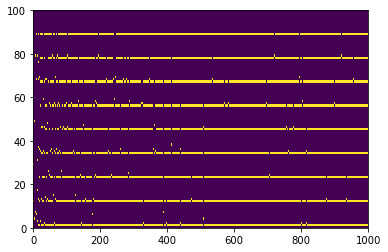

In [14]:
plt.pcolormesh(A)

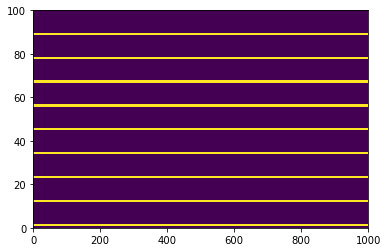

In [10]:
plt.pcolormesh(np.repeat(dijk(path_means1.reshape(L,))[1],iters).reshape(L,iters))

In [ ]:
plt.pcolormesh(np.repeat(dijk(path_means1.reshape(L,))[1],10).reshape(L,10))